In [1]:
import os
import sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
# Compute the parent directory (project root)
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
# Insert the project root into sys.path if it's not already there
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [2]:
import numpy as np
from registry import get_registry
from dual_datasets import VIGORDataset
from utils import get_data_transforms, process_data
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from qualitative_utils import get_images, get_heatmap_array, show_ground, get_heatmap, show_image, get_distance_array
from tqdm import tqdm

/home/qngo/semester-project-vita/CCVPE/.venv/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


In [3]:
dataset_root='/work/vita/qngo/VIGOR'
area = 'samearea'
training = False # test dataset
pos_only = True
transform_grd, transform_sat = get_data_transforms()

vigor = VIGORDataset(dataset_root, 
                 split=area, 
                 train=training, 
                 pos_only=pos_only, 
                 transform=(transform_grd, transform_sat),
                 use_osm_tiles=True)

loaded data pikle
osm tiles loaded for NewYork
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/NewYork/satellite_list.txt 23279
loaded data pikle
osm tiles loaded for Seattle
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/Seattle/satellite_list.txt 44055
loaded data pikle
osm tiles loaded for SanFrancisco
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/SanFrancisco/satellite_list.txt 68310
loaded data pikle
osm tiles loaded for Chicago
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/Chicago/satellite_list.txt 90618
Sat loaded, data size:90618
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/NewYork/same_area_balanced_test.txt 13884
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/Seattle/same_area_balanced_test.txt 25759
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/SanFrancisco/same_area_balanced_test.txt 39866
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/Chicago/same_area_balanced_test.txt

In [4]:
def load_distances(experiment_name, base_path):
    return np.load(os.path.join(base_path, experiment_name, "distance_test.npy"))

base_path = '/work/vita/qngo/test_results'
experiment_name = 'hard_select_fusion'
distances = load_distances(experiment_name, base_path)

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_wrapper = get_registry('hard_select_fusion')('hard_select_fusion', device)

def load_model(model_wrapper, base_model_path: str, model_name: str, epoch: int):
    epoch = str(epoch)
    model_path = os.path.join(base_model_path, model_name, epoch, "model.pt")
    model_wrapper.load_model(model_path)

epoch='10'
base_model_path = "/work/vita/qngo/models/VIGOR/"
load_model(model_wrapper, base_model_path, experiment_name, epoch=epoch)
model_wrapper.set_model_to_eval()

distance_array = distances

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


/home/qngo/semester-project-vita/CCVPE/wrappers/hardSelectWrapper.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


In [9]:
distance_array[2]

np.float64(17.992048263549805)

np.float64(37.4238166809082)

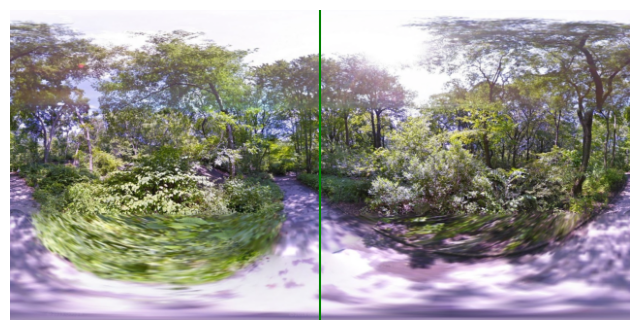

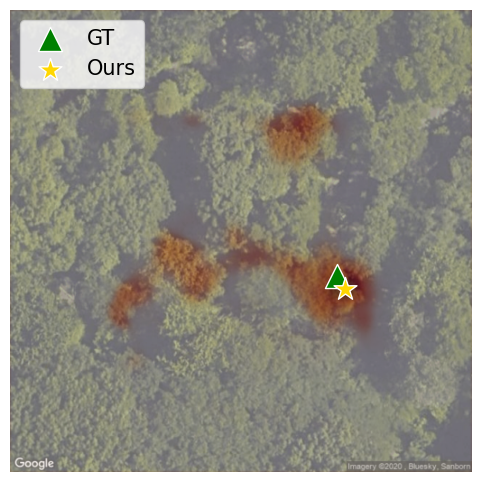

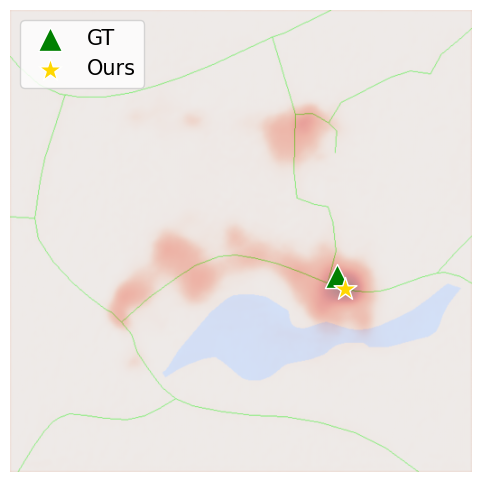

In [6]:
idx = 679
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
for d in data:
    try:
        d = d.unsqueeze(0).to(device)
    except:
        pass
        
output, loss, heatmap = model_wrapper.infer(data)
grd, sat, osm, gt = get_images(idx, vigor)
show_ground(grd)
show_image(sat, grd, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt)
show_image(osm, grd, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt)

distance_array[idx]